# Solving the Incompressible Semi-Geostrophic Problem in 2D

First load in the neccessary packages and paths.

In [1]:
import initialconditions as ic
import matplotlib.pyplot as plt
import numpy as np

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

Now set up the initial condition and visualize it.

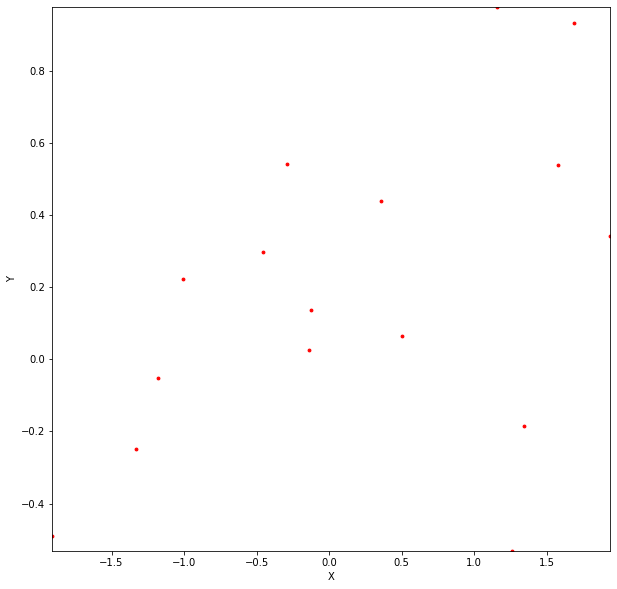

In [2]:
# Define the parameters of the system

N = 16 # Number of seeds
box = [-2, -1, 2, 1] # list or tuple defining domain [xmin, ymin, xmax, ymax]
per_tol = 1e-3 # Percent tolerance
periodic_x = True # Set the periodicity of X
periodic_y = False # Set the periodicity of Y
a = 2 # Set the replication parameter
tf = 0.1 # Final time
Ndt = 10 # Number of timesteps

#Initialize initial condition

Z = ic.create_artifical_initial(N, box[0], box[1], box[2], box[3], 'uniform', 0.8) 

#Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z[:,0], Z[:,1], color= 'red', s = 8)
ax.set_xlim([np.min(Z[:,0]), np.max(Z[:,0])])
ax.set_ylim([np.min(Z[:,1]), np.max(Z[:,1])])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

Solve the problem and save the data

In [ ]:
main.SG_solver(box, Z, N, per_tol, tf, Ndt, periodic_x, periodic_y, a) #Solve and save the solution

#Can specify solver and debug mode.

Animate the solutions

In [ ]:
from pysdot import PowerDiagram
from pysdot.domain_types import ConvexPolyhedraAssembly
import pyvista as pv
import imageio.v2 as iio

ani.point_animator('./SG_data.npz', 'C', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 
ani.point_animator('./SG_data.npz', 'Z', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 

# Animate the cells

#Construct domain
domain = ConvexPolyhedraAssembly()
domain.add_box([box[0], box[1]], [box[2], box[3]])

# Load the data
loaded_data = np.load('./SG_data.npz')

# Access the individual arrays
Z = loaded_data['data1']
C = loaded_data['data2']
w = loaded_data['data3']

#Compute Meridonal Velocities to color the cells
f = 1e-4
M = [[0] * len(w[0]) for _ in range(len(w))]
for i in range(len(w)):
    for j in range(len(w[0])):
        M[i][j] = f * (Z[i][j][0] - C[i][j][0])

# Set up the animation parameters
n_frames = len(w)  # Number of frames

# Create an empty list to store frames
frames = []

# Generate frames for the animation
for i in range(n_frames):

    #Draw the tessellation
    pd = PowerDiagram(positions = Z[i] , weights = w[i] , domain = domain)

    # Store the meridonal wind speeds in an array
    vols = np.array(M[i])

    # Save the results in a .vtk file
    filename = "results.vtk"
    pd.display_vtk(filename)

    # Read the data
    grid=pv.read(filename)

    # create cell data that gives the cell volumes, this allows us to colour by cell volumes
    cell_vols = vols[grid.cell_data['num'].astype(int)]
    grid.cell_data['vols']=cell_vols

    # plot the data with an automatically created plotter, for a static picture use backend='static'
    plotter = pv.Plotter(window_size=[800,800], notebook = False, off_screen=True)
    plotter.add_mesh(grid)

    # Render the frame
    plotter.show()

    # Add a headlight
    light=pv.Light(light_type='headlight')
    plotter.add_light(light)

    # Get the frame as an image array
    frame = plotter.screenshot(transparent_background=True)

    # Add the frame to the list of frames
    frames.append(frame)

# Save the frames as an animation file
output_file = './animations/SG_Cell_Animation.gif'
iio.mimwrite(output_file, frames, format='gif', duration = 40)